In [66]:

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error


In [54]:
!unzip "train.csv.zip"

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [56]:
data_train = pd.read_csv('train.csv')
data_train['date'] = pd.to_datetime(data_train['date'])

In [58]:
data_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [59]:
data_train = data_train.groupby('date')[['sales','onpromotion']].sum().reset_index()

In [60]:
data_train.head()

,date,sales,onpromotion
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,0
2,2013-01-03,361461.231124,0
3,2013-01-04,354459.677093,0
4,2013-01-05,477350.121229,0


### LSTM

sales    0
dtype: int64
Epoch 1/60
21/21 - 2s - loss: 0.0922 - val_loss: 0.0420 - 2s/epoch - 97ms/step
Epoch 2/60
21/21 - 0s - loss: 0.0172 - val_loss: 0.0232 - 241ms/epoch - 11ms/step
Epoch 3/60
21/21 - 0s - loss: 0.0156 - val_loss: 0.0210 - 277ms/epoch - 13ms/step
Epoch 4/60
21/21 - 0s - loss: 0.0155 - val_loss: 0.0216 - 246ms/epoch - 12ms/step
Epoch 5/60
21/21 - 0s - loss: 0.0145 - val_loss: 0.0209 - 257ms/epoch - 12ms/step
Epoch 6/60
21/21 - 0s - loss: 0.0158 - val_loss: 0.0207 - 296ms/epoch - 14ms/step
Epoch 7/60
21/21 - 0s - loss: 0.0157 - val_loss: 0.0209 - 237ms/epoch - 11ms/step
Epoch 8/60
21/21 - 0s - loss: 0.0148 - val_loss: 0.0208 - 276ms/epoch - 13ms/step
Epoch 9/60
21/21 - 0s - loss: 0.0151 - val_loss: 0.0210 - 255ms/epoch - 12ms/step
Epoch 10/60
21/21 - 0s - loss: 0.0140 - val_loss: 0.0209 - 319ms/epoch - 15ms/step
Epoch 11/60
21/21 - 0s - loss: 0.0146 - val_loss: 0.0208 - 249ms/epoch - 12ms/step
Epoch 12/60
21/21 - 0s - loss: 0.0143 - val_loss: 0.0211 - 294ms/epoch - 14

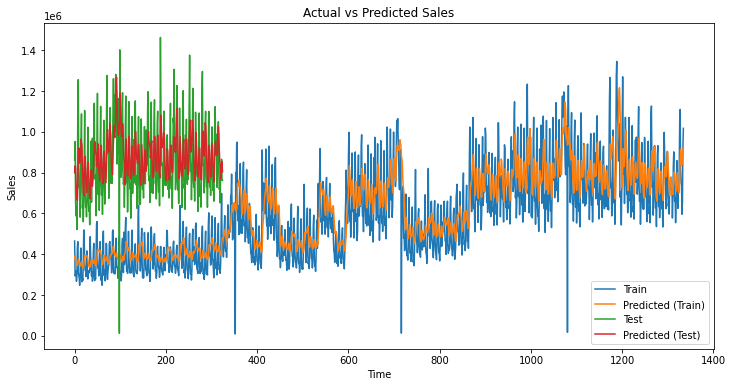

In [63]:

# Convert Date column to datetime format
df=data_train.iloc[:,:2]
df['date'] = pd.to_datetime(df['date'])

# Set Date column as index
df.set_index('date', inplace=True)

# Impute missing values
df.fillna(method='ffill', inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)


# Create training and testing datasets
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:(i+window_size), :])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

window_size = 12
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Build the LSTM model
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)


# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert scaling
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))

# Plot actual vs predicted sales
plt.figure(figsize=(12,6))
plt.plot(y_train[0], label='Train')
plt.plot(train_predict[:,0], label='Predicted (Train)')
plt.plot(y_test[0], label='Test')
plt.plot(test_predict[:,0], label='Predicted (Test)')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.show()


In [65]:
print('Train RMSE: %.2f' % train_rmse)
print('Test RMSE: %.2f' % test_rmse)

Train RMSE: 78492.53
Test RMSE: 113192.21


To develop our model, we aggregated the sales data by day. However, we aim to enhance the model by incorporating the individual store sales data to provide predictions for each store on a given date.